In [5]:
import pandas as pd
import numpy as np

from sklearn.utils import shuffle

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import FunctionTransformer, MaxAbsScaler, LabelEncoder
from sklearn.impute import SimpleImputer as Imputer # if we also look at numeric features
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.model_selection import train_test_split

from utils import combine_text_columns, SparseInteractions

from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

df = pd.read_csv("data/training_set.csv")

df = df.dropna()

SCORING_METRIC = "roc_auc_ovr"

FEATURES = ["Description"]
LABEL = "Category"
NON_LABELS = [c for c in df.columns if c != LABEL]

# Select k best features in text vectors
chi_k = 300

TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'

#dummy_labels = pd.get_dummies(df[LABEL])
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(df[LABEL])

X_train, X_test, y_train, y_test = train_test_split(df[NON_LABELS], encoded_labels, random_state=42)

get_text_data = FunctionTransformer(lambda x: combine_text_columns(x, to_drop=[LABEL]), validate=False)


pl = Pipeline([
        ('feature_preprocessing ', FeatureUnion(
            transformer_list = [
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', CountVectorizer(token_pattern=TOKENS_ALPHANUMERIC,
                                                   ngram_range=(1, 2))),
                    #('vectorizer', HashingVectorizer(token_pattern=TOKENS_ALPHANUMERIC,
                    #                                 alternate_sign=False, norm=None, binary=False,
                    #                                 ngram_range=(1, 2))),
                    ('dim_red', SelectKBest(chi2, k=chi_k))
                ]))
             ]
        )),
        #('int', SparseInteractions(degree=2)),
        ('scale', MaxAbsScaler()),
        ('clf', OneVsRestClassifier(LogisticRegression(), n_jobs=-1))
    ])

In [8]:
cv = cross_val_score(pl, X_train, y_train, cv=5, scoring=SCORING_METRIC)

print(f"\nMean cross validated {SCORING_METRIC} score: {np.mean(cv)}\n")

for fold, score in enumerate(cv):
    print(f"Score on fold {fold}: {score}")



Mean cross validated roc_auc_ovr score: nan

Score on fold 0: nan
Score on fold 1: nan
Score on fold 2: nan
Score on fold 3: nan
Score on fold 4: nan


C:\Users\Wiktor\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Wiktor\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Wiktor\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py", line 390, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\Wiktor\AppData\Local\Programs\Python\Python310\lib\site-packages\skl

In [7]:
pl.fit(X_train, y_train)
y_pred = pl.predict(X_test)
print("\n", classification_report(y_test, y_pred))

TypeError: sequence item 0: expected str instance, int found

Text(0.5, 1.0, 'Confusion matrix')

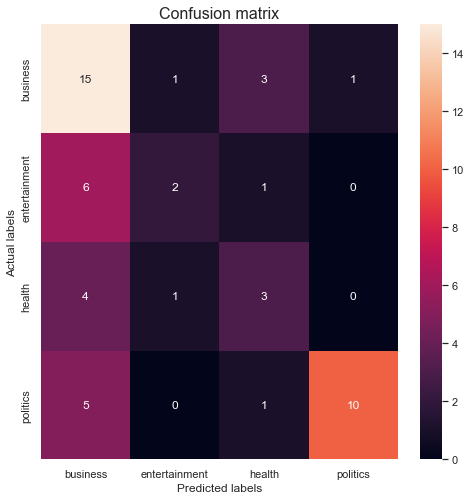

In [ ]:
cm = confusion_matrix(
    y_test,
    y_pred
)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(cm, annot=True, fmt='g', ax=ax,
    xticklabels=encoder.classes_,
    yticklabels=encoder.classes_
)
plt.xlabel('Predicted labels')
plt.ylabel('Actual labels')
plt.title("Confusion matrix", size=16)

In [ ]:
sample = df[LABEL].sample(3)
print(sample)



2391      health
199     business
1235       sport
Name: Category, dtype: object

Text(0.5, 0, 'Number of ocurrences')

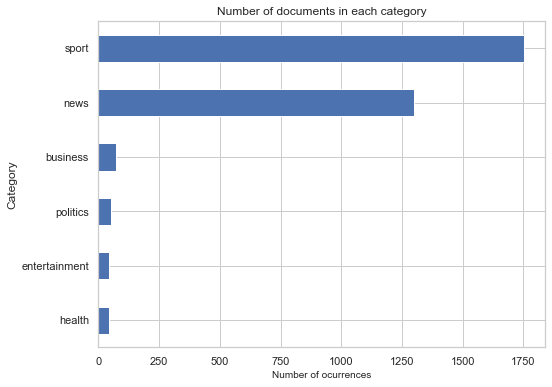

In [ ]:
fig = plt.figure(figsize=(8,6))
df.groupby(LABEL)[FEATURES[0]].count().sort_values().plot.barh(
    ylim = 0, 
    title = 'Number of documents in each category'
    )
plt.xlabel('Number of ocurrences', fontsize = 10)

sport            1751
news             1298
business           74
politics           52
entertainment      43
health             42
Name: Category, dtype: int64